<a href="https://colab.research.google.com/github/enricoaquilina/webnlg2023/blob/main/WebNLG_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [34]:
# Load the Drive helper and mount
from google.colab import drive
# drive.mount('/content/drive')

In [2]:
%%capture
!pip install sentencepiece
!pip install transformers
!pip install timm

In [3]:
import gc
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')
import os


In [4]:
if torch.cuda.is_available():
   dev = torch.device("cuda:0")
   print("Running on the GPU")
else:
   dev = torch.device("cpu")
   print("Running on the CPU")

Running on the GPU


# Pre-training

## Load dataset

In [5]:
import math
train_df = pd.read_csv('/content/drive/MyDrive/WebNLG/2023-Challenge/data/processed/webNLG2020_train(comma separated input and output, unicode removal).csv', index_col=[0])
train_df=train_df.iloc[:4500,:]
train_df=train_df.sample(frac=1)
batch_size=8
num_of_batches=math.floor(len(train_df)/batch_size)

In [6]:
num_of_batches

562

In [7]:
train_df.shape

(4500, 2)

In [8]:
train_df

,input_text,target_text
57,Al-Taqaddum_Air_Base | location | Habbaniyah,Il-Bazi tal-Ajru Al Taqaddum tinsab f Habbaniy...
1948,France | leader | Francois_Hollande,Il-mexxejja ta Franza huwa Francois Hollande....
3846,U.S._Citta_di_Palermo | manager | Giuseppe_Iac...,Abel Hernandez jindika l-klub U.S. Citta di Pa...
3983,Asilomar_Conference_Grounds | architect | Juli...,Julia Morgan minn San Francisco kienet id-disi...
4169,"Albany_Oregon | country | United_States,Albany...",L-Istati Uniti jinkludu l-grupp etniku ta Ame...
...,...,...
3304,Amsterdam_Airport_Schiphol | elevationAboveThe...,L-Ajruport ta Amsterdam Schiphol f Haarlemmer...
2063,AIDAluna | length | 252000.0 (millimetres),"L-AIDAluna hija fit-tul ta 252 metru.,L-AIDAl..."
2123,Abarth_1000_GT_Coupe | bodyStyle | Coupe,L-Abarth 1000 GT ghandu l-istil tal-gisem tal-...
4233,Arlington_Texas | isPartOf | Tarrant_County_Te...,Forth Worth huwa s-sede tal-kontea tal-Konte t...


In [9]:
%%capture
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration,Adafactor

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base',
                                             return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

In [10]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [11]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        
            {value}
        
    """.format(loss=loss,value=value, max=max))

In [14]:
num_of_epochs=10


## Initiate training

In [15]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):

    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      # input = 'WebNLG: '+row['input_text']+'</s>' 
      # labels = row['target_text']+'</s>'    
      input = row['input_text']
      labels = row['target_text']
      inputbatch.append(input)
      labelbatch.append(labels)
    # inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=1000,return_tensors='pt')["input_ids"]
    # labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=1000,return_tensors="pt") ["input_ids"]
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=1000,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=1000,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
  
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.24864364533396802
Running epoch: 2


Epoch: 2 , Running loss: 0.21114176608542531
Running epoch: 3


Epoch: 3 , Running loss: 0.18270565451411167
Running epoch: 4


Epoch: 4 , Running loss: 0.16012677329582464
Running epoch: 5


Epoch: 5 , Running loss: 0.14303211213563471
Running epoch: 6


Epoch: 6 , Running loss: 0.12766927550298252
Running epoch: 7


Epoch: 7 , Running loss: 0.11650171183924658
Running epoch: 8


Epoch: 8 , Running loss: 0.1064735544162713
Running epoch: 9


Epoch: 9 , Running loss: 0.0981668124499058
Running epoch: 10


Epoch: 10 , Running loss: 0.08978608191954601


## Plot loss

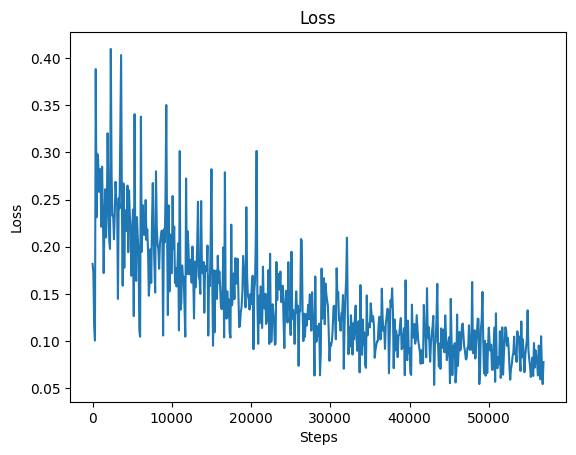

In [16]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

## Test model

In [17]:
model.eval()
input_ids = tokenizer.encode("Russia | leader | Putin", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0], skip_special_tokens=True)
     

'Il-mexxej tar-Russja huwa Putin'

# Load pre-trained model from HF

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("eaqui/T5_webnlg")

model = AutoModelForSeq2SeqLM.from_pretrained("eaqui/T5_webnlg")

In [18]:
model.to(dev)
model.eval()
input_ids = tokenizer.encode("Russia | leader | Putin", return_tensors="pt")  # Batch size 1
outputs = model.generate(input_ids.to(dev))
tokenizer.decode(outputs[0], skip_special_tokens=True)

'Il-mexxej tar-Russja huwa Putin'

In [19]:
def generate(text):
  # model.to(dev)
  model.eval()
  input_ids = tokenizer.encode(text, return_tensors="pt")  # Batch size 1
  s = time.time()
  outputs = model.generate(input_ids.to(dev))
  gen_text=tokenizer.decode(outputs[0], skip_special_tokens=True)
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  return gen_text

In [20]:
generate('Russia | leader | Putin')

Generated in 0.30 seconds


'Il-mexxej tar-Russja huwa Putin'

In [22]:
generate('Sidhath | profession | Doctor , Sidharth | home_town |  Bombay')

Generated in 0.78 seconds


'Sidhath kien gradwat mill-Istitut'

In [29]:
generate('Nie_Haisheng | birthDate | 1964-10-13,Nie_Haisheng | occupation | Fighter_pilot ')

Generated in 0.51 seconds


'Nieuhaisheng twieled fit-13 ta Ottubru 1964'

In [27]:
generate('Bananaman | creator | Steve_Bright,Bananaman | broadcastedBy | BBC')

Generated in 0.44 seconds


'Il- BBC xxandiet il-Bananaman mibg'

In [28]:
generate('Bananaman | lastAired | "1986-04-15",Bananaman | creator | Steve_Bright')

Generated in 0.46 seconds


'Il-Bananaman li ntbaghat l-e'

In [33]:
generate('Alan B. Miller Hall | currentTenants | Mason School of Business,Alan B. Miller_Hall | location | Williamsburg Virginia')

Generated in 0.46 seconds


'L-Iskola Mason of Business jinsab f Williamsburg'

# Quantization

In [ ]:
import torch.quantization
import torch.nn as nn

quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear,nn.Dropout,nn.LayerNorm}, dtype=torch.qint8
)


In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(quantized_model)

Size (MB): 891.712182
Size (MB): 322.000103


In [ ]:
def quant_generate(text):
  quantized_model.eval()
  input_ids = tokenizer.encode("WebNLG:{} ".format(text), return_tensors="pt")  # Batch size 1
  s = time.time()
  outputs = quantized_model.generate(input_ids.to(dev))
  gen_text=tokenizer.decode(outputs[0], skip_special_tokens=True).replace('[','').replace("'","")
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  
  return gen_text

In [ ]:
quant_generate('Facebook | CEO | Mark  && Facebook | number Of Employees | 52000 ')

Generated in 3.67 seconds


'Il- CEO tal-Facebook huwa 52000'

In [ ]:
generate('Facebook | CEO | Mark  &&  Facebook | number Of Employees | 52000 ')

Generated in 0.46 seconds


'Mark huwa l- CEO tal-Ajruport'

# Upload model to Hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model.push_to_hub("eaqui/T5_webnlg")
tokenizer.push_to_hub('T5_webnlg')
# torch.save(model.state_dict(),'pytorch_model.bin')

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/eaqui/T5_webnlg/commit/78585142c9635e63040fb00d7d18326e11f6235b', commit_message='Upload tokenizer', commit_description='', oid='78585142c9635e63040fb00d7d18326e11f6235b', pr_url=None, pr_revision=None, pr_num=None)